In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi, cos, sin
%matplotlib inline

Each being is defined by dictionnary with keys <code>((position_x, position_y), move_range, satiation, type_id, edible_spicies_id, cell_position)</code>

In [2]:
class Being:
    def __init__(self,
                 species,
                 position,
                 map_shape):
        (
            self.move_range,
            self.satiation,
            self.type_id,
            self.edible_species_id,
            self.color,
            self.reproduction_cooldown,
            self.reproduction_threshold,
            self.hunger_threshold,
            self.direction_change_probability,
            self.random_movement_portion
        ) = species
        self.reproduction_current_cooldown = np.random.rand() * self.reproduction_cooldown
        self.set_position(position, map_shape)
        self.current_direction = self.move_range * (np.random.rand(2) - 1/2)
        self.is_dead = False
        self.position_in_list = None
    
    def set_position_in_list(self, position):
        self.position_in_list = position
    
    def get_position_in_list(self):
        if self.position_in_list == None:
            raise RuntimeError("Position in list not initialized")
        return self.position_in_list
    
    def is_plant(self):
        return len(self.edible_species_id) == 0
    
    def get_int_position(self):
        return tuple(self.position.astype(int))
    
    def get_position(self):
        return tuple(self.position)
    
    def format_position(self, shape, position):
        position = position.copy()
        if (position[0] >= shape[0]):
            position[0] -= shape[0]
        if (position[1] >= shape[1]):
            position[1] -= shape[1]
        if (position[0] < 0):
            position[0] += shape[0]
        if (position[1] < 0):
            position[1] += shape[1]
        return position
    
    def modify_position(self, addition, map_shape, change_position=True):
        if change_position:
            self.position = self.format_position(map_shape, self.position + addition)
            return
        return tuple(self.format_position(map_shape, self.position + addition).astype(int))
        
    def set_position(self, new_position, map_shape):
        self.position = self.format_position(map_shape, new_position)

In [3]:
class Map:
    def __init__(self, beings_count, width, height, species_list):
        self.plant_count_map = np.zeros((width, height))
        self.beings_map = np.zeros((width, height)).astype(set)
        for i in range(width):
            for j in range(height):
                self.beings_map[i, j] = set()
        self.beings_list = []
        self.free_indexes_set = set()
        for i in range(len(beings_count)):
            for j in range(beings_count[i]):
                self.create_being(species_list[i], True)
                
    def create_being(self, species, random_position, position=None):
        if random_position:
            position = np.array((np.random.rand() * self.beings_map.shape[0],
                    np.random.rand() * self.beings_map.shape[1]))
        else:
            position = position.copy()
        being = Being(species,
                      position,
                      self.beings_map.shape)
        if (len(self.free_indexes_set) == 0):
            being.set_position_in_list(len(self.beings_list))
            self.beings_list.append(being)
        else:
            being.set_position_in_list(self.free_indexes_set.pop())
            self.beings_list[being.get_position_in_list()] = being
        self.add_being_to_map(being)
            
    def remove_being_from_map(self, being):
        self.beings_map[being.get_int_position()].remove(being.get_position_in_list())
        if being.is_plant():
            self.plant_count_map[being.get_int_position()] -= 1
    
    def add_being_to_map(self, being):
        self.beings_map[being.get_int_position()].add(being.get_position_in_list())
        if being.is_plant():
            self.plant_count_map[being.get_int_position()] += 1
        
    def move_being(self, being):
        angle = np.random.rand() * 2 * pi
        if np.random.rand() < being.direction_change_probability:
            being.current_direction = being.move_range * (np.random.rand(2) - 1/2)
        self.remove_being_from_map(being)
        being.modify_position(
                                 (
                                     cos(angle) * being.move_range * being.random_movement_portion
                                     + being.current_direction[0] * (1 - being.random_movement_portion),

                                     sin(angle) * being.move_range * being.random_movement_portion
                                     + being.current_direction[1] * (1 - being.random_movement_portion)
                                 ),
                                 self.beings_map.shape
                             )
        self.add_being_to_map(being)
        
    def delete_being(self, being):
        self.remove_being_from_map(being)
        self.free_indexes_set.add(being.get_position_in_list())
        being.is_dead = True
    
    def eat(self, being):
        for i in range(-1, 2):
            for j in range(-1, 2):
                current_cell_position = being.modify_position((i,j), self.beings_map.shape, change_position=False)
                for being_index in self.beings_map[current_cell_position]:
                    if (not self.beings_list[being_index].is_dead
                            and being.get_position_in_list() != self.beings_list[being_index].get_position_in_list()
                            and self.beings_list[being_index].type_id in being.edible_species_id
                            ):
                        being.satiation += self.beings_list[being_index].satiation / 2
                        self.delete_being(self.beings_list[being_index])
                        return True
        return False
    
    def reproduction(self, being):
        being.reproduction_current_cooldown = being.reproduction_cooldown * (np.random.rand() + 0.5)
        being.satiation /= 2
        species = (
                       being.move_range,
                       being.satiation,
                       being.type_id,
                       being.edible_species_id.copy(),
                       being.color,
                       being.reproduction_cooldown,
                       being.reproduction_threshold,
                       being.hunger_threshold
                  )
        if being.is_plant():
            self.create_being(species, True, position=position)
        else:
            position = being.get_position() + np.random.rand(2) - 0.5
        self.create_being(species, True, position=position)
    
    def iterate_being(self, being):
        if being.reproduction_current_cooldown > 0:
            being.reproduction_current_cooldown -= 1
        if being.is_plant():
            being.satiation += 1 / self.plant_count_map[being.get_int_position()] - 0.45
        else:
            being.satiation -= 1
        if (being.satiation <= 0):
            self.delete_being(being)
            return
        if (being.satiation < being.hunger_threshold and not being.is_plant()):
            if self.eat(being):
                return
        if (being.satiation > being.reproduction_threshold
                and being.reproduction_current_cooldown <= 0):
            self.reproduction(being)
        if not being.is_plant():
            self.move_being(being)

    def iteration(self):
        for being in self.beings_list:
            if not being.is_dead:
                self.iterate_being(being)

In [4]:
species = [(0.1, 130, 0, {2}, (0, 0, 1, 1), 200, 101, 1000, 0.01, 0.15),
           (0.4, 130, 1, {0}, (1, 0, 0, 1), 400, 801, 1000, 0.01, 0.15),
           (0, 10, 2, set(), (0, 0.8, 0.2, 1), 50, 60, 1000, 0.01, 0.15)]

the_map = Map([30, 1, 2000], 30, 30, species)

<IPython.core.display.Javascript object>


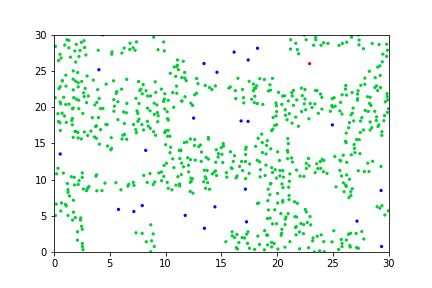

In [5]:
%matplotlib notebook

import numpy as np
import matplotlib.animation as animation

plt.close('all')


fig = plt.figure(5)
ax = plt.axes(xlim=(0, the_map.beings_map.shape[0]), ylim=(0, the_map.beings_map.shape[1]))
scat = ax.scatter([], [], s=60)
#plt.xticks([]), plt.yticks([])


def init():
    scat.set_offsets([])

def update(*args):
    positions = []
    colors = []
    for i in range(len(the_map.beings_list)):
        if not the_map.beings_list[i].is_dead:
            positions.append(the_map.beings_list[i].get_position())
            colors.append(the_map.beings_list[i].color)
    scat.set_offsets(positions)
    scat.set_color(colors)
    scat.set_sizes(5 * np.ones(len(the_map.beings_list)))
    the_map.iteration()
    return scat,

anim = animation.FuncAnimation(fig, update, init_func=init, frames=range(100),
                               interval=50)
plt.show()

In [7]:
def get_population(beings_list):
    result = {}
    for being in beings_list:
        if being.is_dead:
            continue
        if not being.type_id in result.keys():
            result[being.type_id] = 1
        else:
            result[being.type_id] += 1
    return result

In [8]:
def draw_population(beings_map, beings_list, free_indexes_set, plant_count_map, iteration_number, iterations_per_step, species_to_draw=None):
    graphics = {}
    inital_population = get_population(beings_list)
    population = get_population(beings_list)
    for type in inital_population:
        graphics[type] = []
    for current_iteration in range(iteration_number):
        for type in inital_population:
            if not type in population:
                graphics[type].append(0)
            else:
                graphics[type].append(population[type])
        for i in range(iterations_per_step):
            the_map.iteration()
        population = get_population(beings_list)
    plt.close('all')
    fig = plt.figure(figsize=(12, 6))
    for type in inital_population:
        if not species_to_draw == None and not type in species_to_draw:
            continue
        subplot = plt.subplot((len(inital_population.keys()) // 3 + 1) * 100 + 30 + 1 + type)
        subplot.set_xlim((0, iteration_number))
        subplot.plot(graphics[type])
    plt.show()
    fig = plt.figure(figsize=(12, 6))
    for type in inital_population:
        if not species_to_draw == None and not type in species_to_draw:
            continue
        subplot = plt.subplot(111)
        subplot.set_xlim((0, iteration_number))
        subplot.semilogy(graphics[type])
    plt.show()

<IPython.core.display.Javascript object>


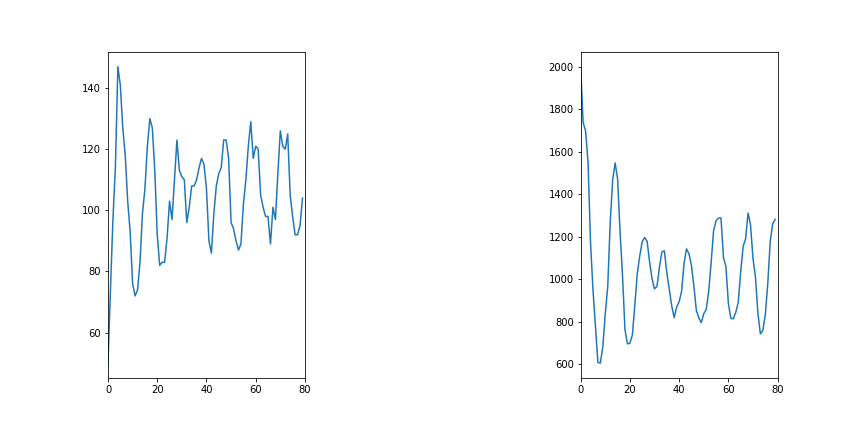

<IPython.core.display.Javascript object>


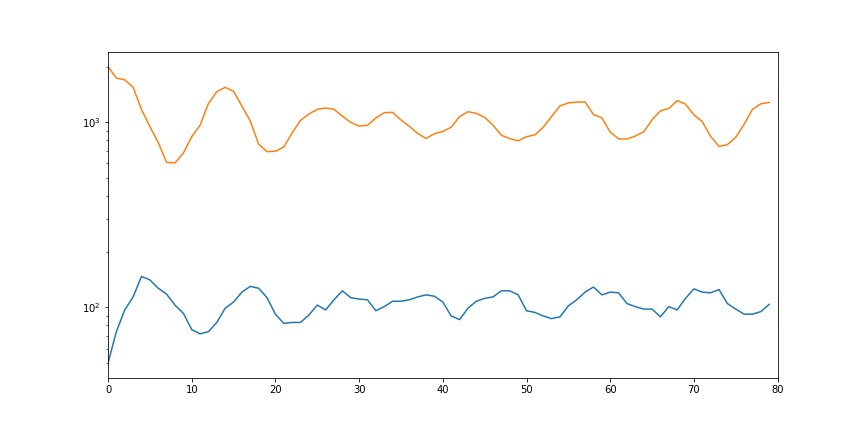

In [15]:
draw_population(the_map.beings_map, the_map.beings_list, the_map.free_indexes_set, the_map.plant_count_map, 80, 60, species_to_draw={0, 1, 2})